# Multi-Class Text Classification Model Comparison and Selection

### Data
We are using a relatively large data set of Stack Overflow questions and tags. The data is available in Google BigQuery, it is also publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv.

## Importing data

In [ ]:
# General imports
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# sklearn imports for ML (prepare, modeling, and evaluate)
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Import data and visualize it
filename = "stack-overflow-data_very_short.csv"
data = pd.read_csv(filename)

print("Data Info:")
print(data.info())
data.head(10)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    570 non-null    object
 1   tags    570 non-null    object
dtypes: object(2)
memory usage: 9.0+ KB
None


post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs

<ipython-input-10-d051d34c0b83>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.index, y=tag_counts.values, palette='viridis')


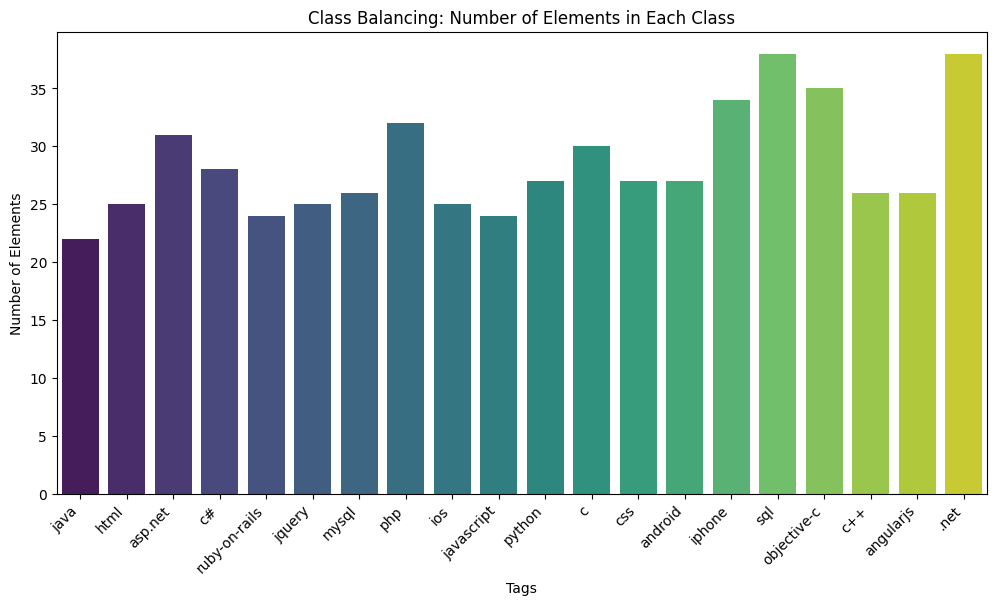

In [ ]:
# Visualization : class balancing
my_tags = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']
# Build a visualization: the number of elements in each class (tag)

# Count the occurrences of each tag in the dataset
tag_counts = data['tags'].value_counts().reindex(my_tags, fill_value=0)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette='viridis')
plt.title('Class Balancing: Number of Elements in Each Class')
plt.xlabel('Tags')
plt.ylabel('Number of Elements')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# How many words are in the data set ?

total_words = data['post'].apply(lambda x: len(str(x).split())).sum()

print("Total number of words in the dataset:", total_words)

Total number of words in the dataset: 78660


### What do you observe ?
There are the same number of elements in each class. The classes are balanced. (https://towardsdatascience.com/why-balancing-classes-is-over-hyped-e382a8a410f7)

In [ ]:
# Post and tag details : pint a post and a tag (a line)
# The idea is to visualize the differents steps of processing

index = 0
post = data.loc[index, 'post']
tag = data.loc[index, 'tags']

print(f"Post: {post}\nTag: {tag}")

Post: what is causing this behavior  in our c# datetime type  <pre><code>[test] public void sadness() {    var datetime = datetime.utcnow;    assert.that(datetime  is.equalto(datetime.parse(datetime.tostring()))); } </code></pre>   failed :   <pre><code> expected: 2011-10-31 06:12:44.000  but was:  2011-10-31 06:12:44.350 </code></pre>   i wish to know what is happening behind the scenes in tostring() etc to cause this behavior.    edit after seeing jon s answer :   <pre><code>[test] public void newsadness() {     var datetime = datetime.utcnow;     assert.that(datetime  is.equalto(datetime.parse(datetime.tostring( o )))); } </code></pre>   result :   <pre><code>expected: 2011-10-31 12:03:04.161 but was:  2011-10-31 06:33:04.161 </code></pre>   same result with capital and small  o  . i m reading up the docs  but still unclear.
Tag: c#


In [ ]:
# Print a different post and tag/label (different line)

another_index = 5
another_post = data.loc[another_index, 'post']
another_tag = data.loc[another_index, 'tags']

print(f"Another Post: {another_post}\nTag: {another_tag}")

Another Post: how to give alias name for my website  i have deployed my asp.net site in one of our server which is in ip format. so  i used to browse it like… <code>http://xx.xx.xx.xx/mysite</code>    but  i want to get out of this ip and give some text. how can i achieve this.    also  i can’t change the host alias name.
Tag: asp.net


## Text Pre-processing
Create a function <b>'clean_words'</b>, which will contain methods to remove different types of noise from the words.

In [ ]:
from bs4 import BeautifulSoup

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(['the', 'and', 'is', 'in', 'for', 'to', 'it', 'of'])

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    # HTML decoding with BeautifulSoup
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Lowercase text
    text = text.lower()

    # Replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)

    # Delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE, '', text)

    # Delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)

    return text

# Apply to dataset and visualize the result with an example

example_index = 2  # Change this index to visualize a different post
example_post = data.loc[example_index, 'post']
cleaned_example_post = clean_text(example_post)

print(f"Original : {example_post}")
print(f"Cleaned : {cleaned_example_post}")

Original : how to convert a float value in to min:sec  i m trying to convert my second in min:sec. my code is:    <pre><code>- (ibaction)calcola:(id)sender  {     float grandezzakb= [[fieldgrandezza text] floatvalue];     float velocitambps= [[fieldvelocita text] floatvalue] ;     float grandezzamb= grandezzakb*1000;     float velocitakb = velocitambps*128;     float seconditotali = grandezzamb/velocitakb;     float min = seconditotali / 60;      nsstring *risultato = [nsstring stringwithformat:@ %.02f minuti   min];      [labelrisultato settext:risultato]; } </code></pre>   sorry if it isn t english but i m italian :d someone can help me  i ve already tried with the mod but it doesn t work with float :( sorry if the code isn t perfect  but i m a newbie :)
Cleaned : how convert a float value minsec i m trying convert my second minsec my code ibaction calcola id sender float grandezzakb fieldgrandezza text floatvalue float velocitambps fieldvelocita text floatvalue float grandezzamb gra

In [ ]:
# Word count after the pre-processing. How many words are in the data set ?
# Do you see any difference with the Previous dataset?

# Apply clean_text function to the dataset
data['cleaned_post'] = data['post'].apply(clean_text)

# Calculate word count after pre-processing
total_words_after_preprocessing = data['cleaned_post'].apply(lambda x: len(str(x).split())).sum()

print("Total number of words in the dataset after pre-processing:", total_words_after_preprocessing)

<ipython-input-23-f4941c776b0d>:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Total number of words in the dataset after pre-processing: 64289


In [ ]:
# Split the data into train and test datasets using train_test_split method from sklearn
# Use X the explicative parameters and y the value to predict

X = data['cleaned_post']
y = data['tags']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (456,)
X_test shape: (114,)
y_train shape: (456,)
y_test shape: (114,)


## Classification

### Naive Bayes Classifier for Multinomial Models

In [ ]:
#Build a pipeline with the CountVectorizer, then  TfidfTransformer and MultinomialNB model
# YOUR CODE HERE

# train the model
# YOUR CODE HERE

# Store the prediction iin a variable y_pred
# YOUR CODE HERE

# visualize the accuracy and the classification report
# YOUR CODE HERE

### Support vertor Machine

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

#Build a pipeline with the SGDClassifier model with the following parameters:
# loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# train the model
# YOUR CODE HERE

# Train the model
text_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = text_clf.predict(X_test)

# Visualize the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 34.21%

Classification Report:
               precision    recall  f1-score   support

         .net       0.08      0.80      0.14         5
      android       1.00      0.33      0.50         6
    angularjs       1.00      0.10      0.18        10
      asp.net       0.17      0.33      0.22         3
            c       0.40      0.67      0.50         3
           c#       0.00      0.00      0.00        10
          c++       1.00      0.33      0.50         3
          css       0.60      0.60      0.60         5
         html       0.00      0.00      0.00         5
          ios       0.00      0.00      0.00         5
       iphone       0.80      0.50      0.62         8
         java       0.00      0.00      0.00         4
   javascript       0.00      0.00      0.00         5
       jquery       0.12      0.33      0.18         3
        mysql       0.00      0.00      0.00         2
  objective-c       0.50      0.83      0.62         6
          php       1.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression

In [ ]:
#Build a pipeline with the LogisticRegression model with the following parameters: n_jobs=1, C=1e5
logreg_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(n_jobs=1, C=1e5))
])

# train the model
logreg_clf.fit(X_train, y_train)

# Store the prediction iin a variable y_pred
y_pred_logreg = logreg_clf.predict(X_test)

# visualize the accuracy and the classification report
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg:.2%}\n")

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 57.02%

Logistic Regression Classification Report:
               precision    recall  f1-score   support

         .net       0.40      0.80      0.53         5
      android       1.00      0.83      0.91         6
    angularjs       1.00      0.30      0.46        10
      asp.net       0.50      1.00      0.67         3
            c       0.33      0.67      0.44         3
           c#       0.00      0.00      0.00        10
          c++       1.00      0.67      0.80         3
          css       0.50      0.60      0.55         5
         html       0.33      0.20      0.25         5
          ios       0.00      0.00      0.00         5
       iphone       0.57      0.50      0.53         8
         java       0.29      0.50      0.36         4
   javascript       0.33      0.20      0.25         5
       jquery       0.25      0.67      0.36         3
        mysql       0.00      0.00      0.00         2
  objective-c       0.44      0.67    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Comment and compare the results.

Naive Bayes:

    Accuracy: 34.21%
    Macro avg F1-score: 0.29
    Weighted avg F1-score: 0.33

Logistic Regression:

    Accuracy: 57.02%
    Macro avg F1-score: 0.52
    Weighted avg F1-score: 0.54

The Logistic Regression model generally provides better performance, as indicated by the higher accuracy and F1-scores.

#### Can you build a better model using another algorithm?

I can try using a Support Vector Machine (SVM) classifier, which is known for its effectiveness in text classification tasks.